En este proyecto se trabajará con una base de datos generada en una clase de Sistemas Digitales en la Universidad de Monterrey durante el semestre de Otoño de 2022. Intentaremos ver si existe alguna relación entre la cercanía que tiene una entrega a la hora de cierre de la bandeja de entrada y la calificación del alumno.

La base de datos contiene dos variables:

**Tiempo:** Tiempo restante para que se cerrara la bandeja, en horas. Es decir, un 1 indica
que entregaron la actividad el domingo a las 11:00 p.m., y un 48 indica que entregaron la
actividad 48 horas antes del domingo a medianoche.

**Calificación:** calificación obtenida en una escala de 0 a 110.  

Empezaremos por importar la base de datos y luego se van a graficar los datos con un scatter para ver la tendencia que tienen.

En la base de datos se incluían algunos valores atípicos en la forma de strings de carácteres en lugar de números. Se tuvieron que borrar esos 4 datos.


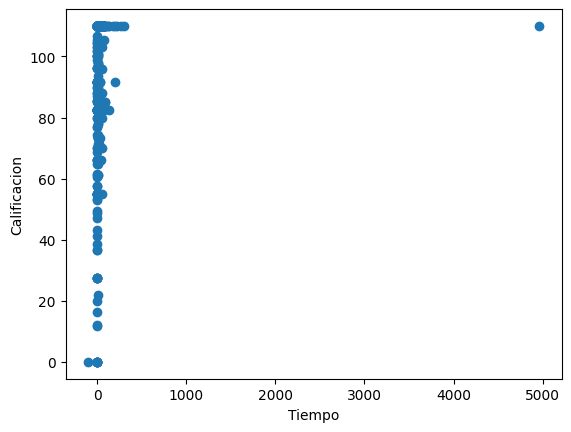

In [62]:
import pandas as pd
df = pd.read_csv('A1.6 Tiempo de Entrega.csv')
df.head()

import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(df.Tiempo, df.Calificacion)
plt.xlabel('Tiempo')
plt.ylabel('Calificacion')
plt.show()


En la gráfica podemos observar que casi todas las tareas se entregaron antes de las 1000 horas, excepto por una que se entregó alrededor de 5000 horas antes. Esto es un dato irracional tomando en cuenta que el semestre dura alrededor de 16 semanas. Estamos hablando de una persona que entregó su tarea 208 días antes en un semestre que dura aproximadamente 112 días. Este dato está mal y se debe filtrar.

Una vez filtrado volveremos a graficar. También observamos datos menores a 0, lo cual no tiene sentido, así que también es necesario filtrarlos.


       Tiempo  Calificacion
29   4960.167         110.0
107  -100.000           0.0
(428, 2)
(426, 2)


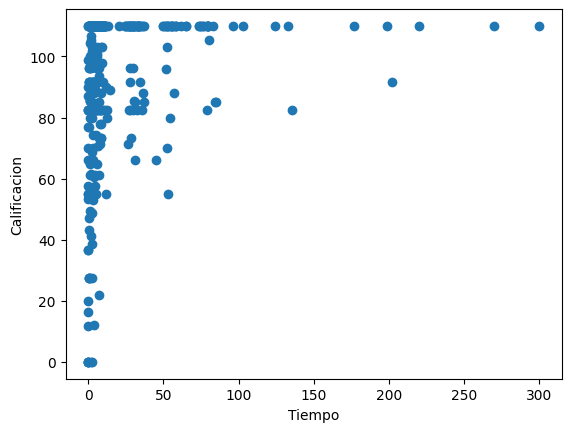

In [63]:
import numpy as np
#Encontrar outlier
out = np.where((df.Tiempo>1000) | (df.Tiempo<0))[0]
print(df.iloc[out,:])

#Con este print podremos observar que se borra una observación

print(df.shape)
#Borrando observacion
df = df.drop(index = out)
#observamos una observación menos
print(df.shape)

#otra gráfica
plt.scatter(df.Tiempo, df.Calificacion)
plt.xlabel('Tiempo')
plt.ylabel('Calificacion')
plt.show()


Ya que se depuró la base de datos de todos los valores atípicos, se pueden separar los datos de prueba y entrenamiento.



In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train ,Y_test = train_test_split(df.Tiempo, df.Calificacion,train_size= 0.7, random_state= 1302)
print("Valores promedio entrenamiento para x: ",np.mean(X_train),"  para y: ",np.mean(Y_train))
print("Valores promedio prueba para x: ",np.mean(X_test),"  para y: ",np.mean(Y_test))
#

Valores promedio entrenamiento para x:  17.477582960697983   para y:  94.86075697986577
Valores promedio prueba para x:  18.742215710992188   para y:  95.219553125


Los valores promedio entre los datos de prueba y de entrenamiento no son muy distintos.
Esto podría ser un problema porque si los datos se parecen demasiado podría ser que no haya una muy buena forma de comprobar cómo se comportaría el modelo con datos que se desvíen un poco más.

Ahora, se va a entrenar un modelo de regresión lineal cuadrático para los datos de entrenamiento usando la función `PolynomialFeatures` de la libreria sklearn.processing, con un parametro de `degree=2`.

Esta función necesita para casos de una sola variable que se acomode de manera particular el arreglo.


In [65]:
#Modifcar forma de los datos
Xtemp_train = X_train.array.reshape(-1,1)
Xtemp_test= X_test.array.reshape(-1,1)
from sklearn.preprocessing import PolynomialFeatures
polyq_train = PolynomialFeatures(degree=2).fit(Xtemp_train)
polyq_test = PolynomialFeatures(degree=2).fit(Xtemp_test)
#Transformar los datos para que incluyan el polinomial de segundo orden.
Xq_train = pd.DataFrame(polyq_train.transform(Xtemp_train))
Xq_test = pd.DataFrame(polyq_test.transform(Xtemp_test))

#Generar y entrenar el modelo
import statsmodels.api as sm
mq = sm.OLS(list(Y_train),Xq_train).fit()
print(mq.summary())
#Predicciones de este modelo
yHat_mq = mq.predict(Xq_test)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     9.146
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           0.000140
Time:                        15:58:39   Log-Likelihood:                -1364.2
No. Observations:                 298   AIC:                             2734.
Df Residuals:                     295   BIC:                             2745.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             90.6247      1.700     53.321      0.0

El modelo presenta una R2 muy mala, pero es relativamente sencillo de interpretar. Entregando las tareas faltando 0 horas para que cierre la bandeja, se estiman 90 puntos. Después, el termino lineal, que es mucho más grande que el cuadrático indica un aumento de calificación por cada hora que se aleja de la tarea, sin embargo el termino cuadrático hace que cada vez ese aumento sea menor.  

Ahora, vamos a intentar a hacer otro modelo de piecewise regression usando la función PiecewiseRegressor de mlinsights.mlmodel.
!pip install mlinsights
La función misma determinará la cantidad de segmentos y la posición de los knots. Usaremos el término cuadrático de los datos de entrenamiento para que cada segmento se comporte de manera cuadrática


In [66]:
from mlinsights.mlmodel import PiecewiseRegressor

ms = PiecewiseRegressor('bins').fit(Xq_train.iloc[:,1:],Y_train)
#Predicciones del modelo
yHat_ms = ms.predict(Xq_test.iloc[:,1:])


  Ahora vamos entrenar otro modelo más utilizando un modelo KNN con un valor de K = *7*

   Usaremos la función KNeighborsRegressor de sklearn.neighbors.

  

In [67]:
from sklearn.neighbors import KNeighborsRegressor as KNN

mk =KNN(n_neighbors=7).fit(Xtemp_train,Y_train)
yHat_mk  = mk.predict(Xtemp_test)


Ahora generaremos el RSE de los tres modelos de regresión y los compararemos para ver cual sería el mejor.

In [68]:
RSS_mq = sum((list(Y_test) - yHat_mq)**2)
RSS_ms = sum((list(Y_test) - yHat_ms)**2)
RSS_mk = sum((list(Y_test) - yHat_mk)**2)

RSE_mq = np.sqrt(RSS_mq/(len(Y_test)-1))
RSE_ms = np.sqrt(RSS_ms/(len(Y_test)-1))
RSE_mk = np.sqrt(RSS_mk/(len(Y_test)-1))


print("RSE modelo cuadrático: ",RSE_mq)
print("RSE modelo piecewise: ",RSE_ms)
print("RSE modelo KNN: ",RSE_mk)


RSE modelo cuadrático:  22.27968849414802
RSE modelo piecewise:  21.17384603753108
RSE modelo KNN:  21.793585879017748


Los tres modelos de regresión tienen un error de alrededor de 20 en un contexto en el que los datos van de 0 a 110, por lo que el error no es tan malo.
Si tuviera que elegir un modelo de los tres basado en lo que tenemos por el momento, probablemente elegiría el modelo piecewise y el cuadrático por sobre el KNN por la interpretabilidad.

Sin embargo, antes de tomar una decisión final conviene ver las gráficas de los 3 modelos.


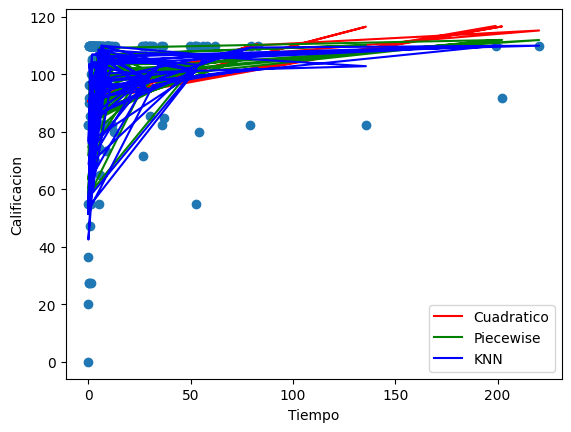

In [69]:
plt.scatter(X_test,Y_test)
plt.plot(X_test,yHat_mq,'r',label="Cuadratico")
plt.plot(X_test,yHat_ms,'g',label="Piecewise")
plt.plot(X_test,yHat_mk,'b',label="KNN")
plt.xlabel('Tiempo')
plt.ylabel('Calificacion')
plt.legend()
plt.show()

Los 3 modelos tienen un desempeño muy similar, por lo que podemos tomar nuestra decisión más bien en la interpretación, que es mucho más sencilla en el modelo cuadrático. En un inicio, hay un aumento por cada cantidad de horas en las que se entrega antes de la hora de entrega, pero ese aumento disminuye entre más horas.
Quizá en un futuro usar un modelo logarítmico podría explicar mejor el modelo.

